In [1]:
%load_ext autoreload
%autoreload 2

### imports and utilities

In [2]:
!pip install nltk scikit-learn matplotlib scipy -q

You should consider upgrading via the 'C:\Users\christian\Documents\christian\work\python\cyberspace\topic_modeler\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\christian\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
from collections import Counter
from utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.special import softmax
from scipy.stats import norm
from scipy.stats import entropy as calculate_entropy

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In C:\Program Files\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Program Files\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Program Files\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


### load dataset

In [5]:
dataset = "newsgroup"

# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.politics.mideast', 'alt.atheism', 'sci.space']

all_docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
all_docs, old_labels, classes = all_docs.data, all_docs.target, all_docs.target_names

In [6]:
# dataset = "bbc"

# data = pd.read_csv('bbcsport.csv')

# all_docs = data["text"].to_list()
# old_labels = data["topic"].to_list()
# categories = classes = np.unique(data["topic"]).tolist()

### clean dataset

In [7]:
datasize = 90
min_document_length = 256
max_document_length = 512


index = -1
docs, labels, label_indices = [], [], []

sizes = [0]*len(categories)

with tqdm(total=len(categories)*datasize) as pbar:
    while sum(sizes) != len(categories)*datasize:
        index += 1
        
        if dataset == "bbc":
            size_index = categories.index(old_labels[index])
            
        else:
            size_index = categories.index(classes[old_labels[index]])
        
        if sizes[size_index] == datasize:
            continue
        
        doc = all_docs[index]
        status, doc, word_count = clean_doc(doc, True)
        
        if not status:
            continue
            
        if min_document_length is not None and len(doc) < min_document_length:
            continue
            
        if max_document_length is not None and len(doc) > max_document_length:
            continue
        
        label_indices.append(size_index)
        labels.append(categories[size_index])
        docs.append(doc)
        sizes[size_index] += 1
        pbar.update(1)

labels = np.array(labels)
label_indices = np.array(label_indices)

In [8]:
index = 3
print(f"Topic: {labels[index]}\n{'='*50}\n{docs[index][:512]}")

Topic: sci.space
sorry folk i should have do this and meant to just after i hit the send key orbital element of comet 1977vii from dance file p au 3 424346 e 0 151899 i 1 0988 cap omega 0 243 5652 w 0 231 1607 epoch 1977 04110 also perihelion of gehrels3 be april 1973 83 jupiter radius august 1970 3 jupiter radius hope this help i m even le of an orbital mechanic than i be an artist


In [9]:
print(sizes)
assert min(sizes) == max(sizes) == datasize

[90, 90, 90, 90]


## Split data

In [10]:
x_train, x_test, y_train, y_test = train_test_split(docs, labels, test_size =.3)

In [11]:
print(f"there are {len(docs)} total docs, {len(y_train)} train and {len(y_test)} test")

there are 360 total docs, 252 train and 108 test


### Initialize Vectorizer

In [12]:
# initialize the count vectorizer
vectorizer = CountVectorizer()

# fit it to dataset
vectorizer.fit(x_train)

vocabulary = np.array(vectorizer.get_feature_names())
print("word_count is", len(vocabulary))

word_count is 3662


### Prepare Datatset

In [13]:
# create doc count vectors
train_doc_vectors = vectorizer.transform(x_train).toarray()
test_doc_vectors = vectorizer.transform(x_test).toarray()

In [14]:
# reduce freq in doc to bin value of 1 or 0
binary = False

word_freq_in_doc_train = pd.DataFrame(train_doc_vectors, columns=vocabulary)
word_freq_in_doc_test = pd.DataFrame(test_doc_vectors, columns=vocabulary)

word_doc_frequency_norm_train = (word_freq_in_doc_train.T / word_freq_in_doc_train.sum(1)).T
word_doc_frequency_norm_test = (word_freq_in_doc_test.T / word_freq_in_doc_test.sum(1)).T

if binary:
    wdf_train = (word_doc_frequency_norm_train > 0).astype(int)
    wdf_test = (word_doc_frequency_norm_test > 0).astype(int)
    
else:    
    wdf_train = word_doc_frequency_norm_train.copy()
    wdf_test = word_doc_frequency_norm_test.copy()

## Word Topic Probability Distr

In [15]:
wdt_train = wdf_train.copy()
wdt_test = wdf_test.copy()

wdt_test["__labels__"] = y_test
wdt_train["__labels__"] = y_train

word_doc_count = wdf_train.sum(0)
topic_doc_count = pd.DataFrame(Counter(y_train), index=[0]).T[0]
word_topic_pr_distr = pd.DataFrame(data=0.0, columns=categories, index=vocabulary)

for category in tqdm(categories):
    pxy = wdf_train[wdt_train["__labels__"] == category].sum(0) / topic_doc_count[category]
    word_topic_pr_distr[category] = pxy * (topic_doc_count[category] / word_doc_count)

print(f"word_topic_pr_distr shape = {word_topic_pr_distr.shape}")


word_topic_pr_distr shape = (3662, 4)


In [16]:
word_topic_pr_distr.head()

,rec.autos,talk.politics.mideast,alt.atheism,sci.space
00,0.411765,0.000000,0.000000,0.588235
000,0.000000,0.208628,0.791372,0.000000
000mi,1.000000,0.000000,0.000000,0.000000
02,1.000000,0.000000,0.000000,0.000000
034101,0.000000,0.000000,0.000000,1.000000


In [17]:
topic_index = 3
topic = categories[topic_index]

print(f"Topwords: Topic - {topic}\n{'='*50}")
word_topic_pr_distr[topic].sort_values(ascending=False).head(10)

Topwords: Topic - sci.space


jpl           1.0
kourou        1.0
jupiter       1.0
sts           1.0
structure     1.0
karla         1.0
strawberry    1.0
stratus       1.0
kit           1.0
kitt          1.0
Name: sci.space, dtype: float64

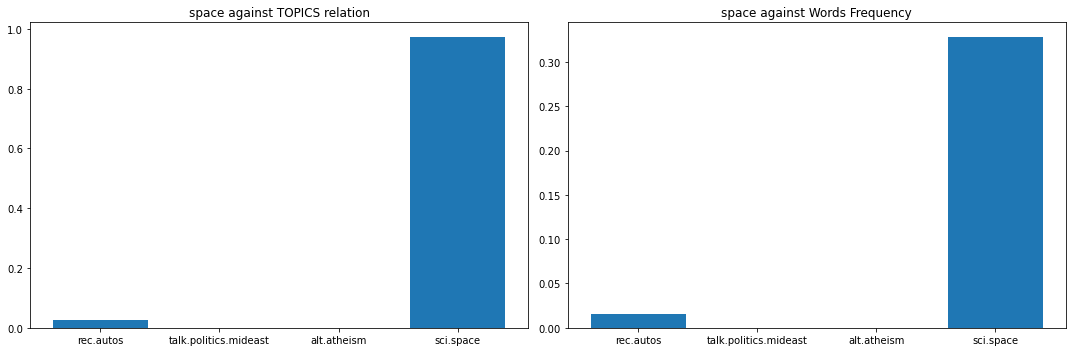

In [18]:
word = "space"

fig = plt.figure(figsize=(15, 5), tight_layout=True)
ax11 = fig.add_subplot(121)
ax12 = fig.add_subplot(122)

ax11.set_title(f"{word} against TOPICS relation")
ax11.bar(word_topic_pr_distr.columns, word_topic_pr_distr.loc[word])

word_topic_freq = Counter(wdt_train["__labels__"][wdt_train[word] > 0])
freqs = []
for topic in word_topic_pr_distr.columns:
#     freqs.append(word_topic_freq[topic])
    freqs.append(word_topic_freq[topic] / topic_doc_count[topic])

ax12.set_title(f"{word} against Words Frequency")
ax12.bar(word_topic_pr_distr.columns, freqs)

plt.show()

### Quick Topic Inference

In [19]:
doc_index = 0
num_of_topwords = 8

doc_index = 0
print(f"Document: {doc_index}, Topic: {y_train[doc_index]}\n{'='*50}\n{x_train[doc_index][:512]}\n")

Document: 0, Topic: rec.autos
i offer to relay this information for a ham friend of mine without internet access his name be robert bob wondolowski n1kda and his car be a 1985 brown cutlas sierra sedan massachusetts plate 716adl his ht yaesu ft415 and mobile antenna be also include in the car it be steal from lynn mass about 10 day ago be on april 6 if anyone have any information about the car s whereabouts please e mail me thank you for take the time to read this message



In [20]:
doc_vector = wdf_train.loc[doc_index]
doc_word_topic_pr_distr, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr)

print(f"Inference: Document {doc_index}\n{'='*50}")
print(f"actual = {wdt_train.loc[doc_index]['__labels__']}, predicted = {predicted_doc_topic}\n")

Inference: Document 0
actual = rec.autos, predicted = rec.autos



In [21]:
print(f"Topwords: Document {doc_index}\n{'='*50}")
print(wdf_train.loc[doc_index].sort_values(ascending=False).head(num_of_topwords))

Topwords: Document 0
be       0.0625
his      0.0375
car      0.0375
the      0.0375
for      0.0250
to       0.0250
this     0.0250
about    0.0250
Name: 0, dtype: float64


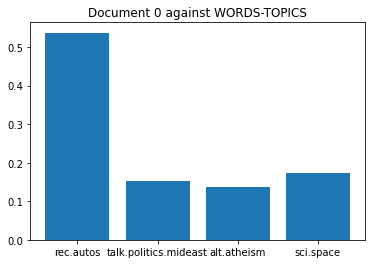

In [22]:
plt.title(f"Document {doc_index} against WORDS-TOPICS")
plt.bar(categories, doc_word_topic_pr_distr.sum(0))
plt.show()

## Topic Word Distr - Train Accuracy

In [23]:
score_train = 0
for doc_index in tqdm(range(len(y_train))):
    doc_vector = wdf_train.loc[doc_index]
    _, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr)
    
    mark = wdt_train.loc[doc_index]['__labels__'] == predicted_doc_topic
    score_train += mark

train_accuracy = score_train * 100 / len(y_train)
print(f"train accuracy = {train_accuracy: .2f}%")


train accuracy =  100.00%


## Topic Word Distr - Test Accuracy

In [24]:
score_test = 0
for doc_index in tqdm(range(len(y_test))):
    doc_vector = wdf_test.loc[doc_index]
    _, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr)
    
    mark = wdt_test.loc[doc_index]['__labels__'] == predicted_doc_topic
    score_test += mark

test_accuracy = score_test * 100 / len(y_test)
print(f"test accuracy = {test_accuracy: .2f}%")


test accuracy =  80.56%


In [25]:
overall_accuracy = (train_accuracy + test_accuracy)/2
print(f"overall_accuracy = {overall_accuracy: .2f}%")

overall_accuracy =  90.28%


### Word Word Probability Distr

In [26]:
word_word_pr_distr = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

for word in tqdm(vocabulary):
    pxy = wdf_train[wdf_train[word] > 0].sum(0) / word_doc_count[word]
#     pxy = (wdf_train.T * wdf_train[word]).sum(1)/ word_doc_count[word]
    word_word_pr_distr[word] = pxy * (word_doc_count[word] / word_doc_count)

print(f"word_word_pr_distr shape = {word_word_pr_distr.shape}")


word_word_pr_distr shape = (3662, 3662)


In [27]:
word_word_pr_distr.head()

,00,000,000mi,02,034101,0565,0710,09,10,100,...,yuru,zealand,zero,zillion,zion,zionism,zionist,zip,zlumber,zone
00,1.0,0.0,0.411765,0.0,0.0,0.0,0.0,0.0,0.588235,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000mi,1.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
034101,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
word = "science"

print(f"Topwords: Word - {word}\n{'='*50}")
word_word_pr_distr[word].sort_values(ascending=False).head(10)

Topwords: Word - science


science     1.0
hidden      1.0
egalon      1.0
organ       1.0
shake       1.0
sometime    1.0
movie       1.0
larc        1.0
mirror      1.0
fiction     1.0
Name: science, dtype: float64

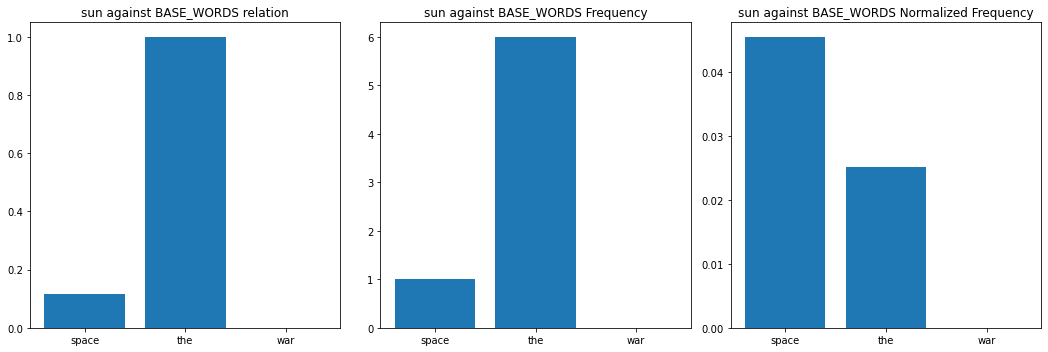

In [29]:
word = "sun"
base_words = ["space", "the", "war"]

fig = plt.figure(figsize=(15, 5), tight_layout=True)
ax11 = fig.add_subplot(131)
ax12 = fig.add_subplot(132)
ax13 = fig.add_subplot(133)

ax11.set_title(f"{word} against BASE_WORDS relation")
ax11.bar(base_words, word_word_pr_distr.loc[word][base_words])

freqs, norm_freqs = [], []
wdc = (wdt_train[base_words] > 0).sum(0)
word_word_freq = (wdt_train[base_words][wdt_train[word] > 0] > 0).sum(0)

for w in base_words:
    freqs.append(word_word_freq[w])
    norm_freqs.append(word_word_freq[w] / wdc[w])

ax12.set_title(f"{word} against BASE_WORDS Frequency")
ax12.bar(base_words, freqs)

ax13.set_title(f"{word} against BASE_WORDS Normalized Frequency")
ax13.bar(base_words, norm_freqs)

plt.show()

## Word distr 2

In [30]:
word_word_pr_distr2 = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

for word in tqdm(vocabulary):
    pxy = (wdf_train.T * wdf_train[word]).sum(1)/ word_doc_count[word]
    word_word_pr_distr2[word] = pxy * (word_doc_count[word] / word_doc_count)

print(f"word_word_pr_distr shape = {word_word_pr_distr.shape}")


word_word_pr_distr shape = (3662, 3662)


In [31]:
word = "science"

print(f"Topwords: Word - {word}\n{'='*50}")
word_word_pr_distr2[word].sort_values(ascending=False).head(10)

Topwords: Word - science


science     0.010417
hidden      0.010417
egalon      0.010417
organ       0.010417
shake       0.010417
sometime    0.010417
movie       0.010417
larc        0.010417
mirror      0.010417
fiction     0.010417
Name: science, dtype: float64

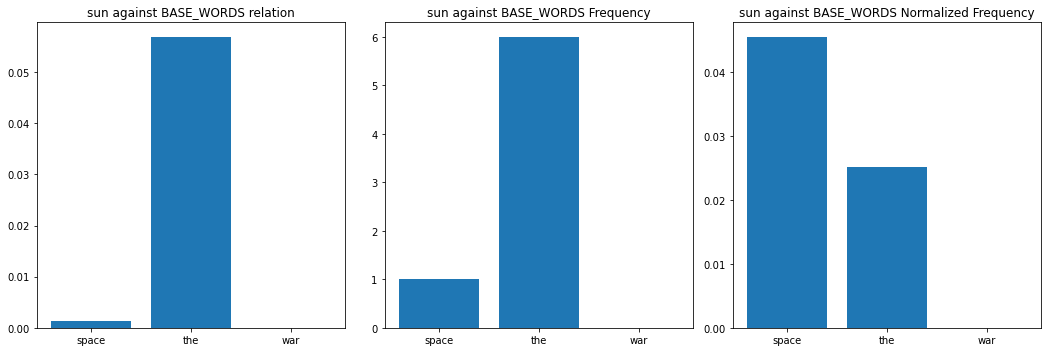

In [32]:
word = "sun"
base_words = ["space", "the", "war"]

fig = plt.figure(figsize=(15, 5), tight_layout=True)
ax11 = fig.add_subplot(131)
ax12 = fig.add_subplot(132)
ax13 = fig.add_subplot(133)

ax11.set_title(f"{word} against BASE_WORDS relation")
ax11.bar(base_words, word_word_pr_distr2.loc[word][base_words])

freqs, norm_freqs = [], []
wdc = (wdt_train[base_words] > 0).sum(0)
word_word_freq = (wdt_train[base_words][wdt_train[word] > 0] > 0).sum(0)

for w in base_words:
    freqs.append(word_word_freq[w])
    norm_freqs.append(word_word_freq[w] / wdc[w])

ax12.set_title(f"{word} against BASE_WORDS Frequency")
ax12.bar(base_words, freqs)

ax13.set_title(f"{word} against BASE_WORDS Normalized Frequency")
ax13.bar(base_words, norm_freqs)

plt.show()

### Montecarlo method

In [33]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers
import tensorflow_addons as tfa

ModuleNotFoundError: No module named 'tensorflow_addons'

In [ ]:
c = [-1, 4]
A = [[-3, 1], [1, 2]]
b = [6, 4]
x0_bounds = (None, None)
x1_bounds = (-3, None)
from scipy.optimize import linprog
res = linprog(c, A_ub=A, b_ub=b, bounds=[x0_bounds, x1_bounds])

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(np.array(categories).reshape(-1, 1))
enc.categories_

In [ ]:
xy_train = enc.transform(y_train.reshape(-1, 1)).toarray()
xy_test = enc.transform(y_test.reshape(-1, 1)).toarray()

xy_train[:3]

In [ ]:
inputs = keras.Input(shape=wdf_train.shape[1:])
outputs = tfa.layers.WeightNormalization(layers.Dense(4, activation="linear"))(inputs)

model = keras.Model(inputs, outputs)
# model.summary()

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
model.fit(wdf_train, xy, epochs=256, validation_split=0.25)

In [ ]:
predictions = model.predict(wdf_test.values)
(predictions.argmax(axis=1) == xy_test.argmax(axis=1)).mean()

In [ ]:
predictions[0], xy_test[0]

In [ ]:
# reduce freq in doc to bin value of 1 or 0
binary = False
test_size = 0.5
alpha, beta = 0.0, 1.0
num_of_iterations = 256
max_num_of_iterations = None
train_sample_accuracy_threshold, test_sample_accuracy_threshold = 0.5, 0.5

assert (alpha + beta) == 1.0, "Alpha and Beta don't add up to 1.0"

# the prime distr
gamma_sum = 0
n_iter = n_all_iter = 0
word_topic_pr_distr_prime = pd.DataFrame(data=0.0, columns=categories, index=vocabulary)

total_iterations = num_of_iterations if max_num_of_iterations is None else max_num_of_iterations

with tqdm(total=total_iterations) as pbar:
    while True:
        if max_num_of_iterations is None and n_iter >= num_of_iterations:
            break
            
        if max_num_of_iterations is not None and n_all_iter >= max_num_of_iterations:
            break
        
        n_all_iter += 1
        if max_num_of_iterations is not None:
            pbar.update(1)
            
        x_train_sample, x_test_sample, y_train_sample, y_test_sample = train_test_split(x_train, y_train, test_size=test_size)

        # create doc count vectors
        train_doc_vectors_sample = vectorizer.transform(x_train_sample).toarray()
        test_doc_vectors_sample = vectorizer.transform(x_test_sample).toarray()

        word_freq_in_doc_train_sample = pd.DataFrame(train_doc_vectors_sample, columns=vocabulary)
        word_freq_in_doc_test_sample = pd.DataFrame(test_doc_vectors_sample, columns=vocabulary)

        word_doc_frequency_norm_train_sample = (word_freq_in_doc_train_sample.T / word_freq_in_doc_train_sample.sum(1)).T
        word_doc_frequency_norm_test_sample = (word_freq_in_doc_test_sample.T / word_freq_in_doc_test_sample.sum(1)).T

        if binary:
            wdf_train_sample = (word_doc_frequency_norm_train_sample > 0).astype(int)
            wdf_test_sample = (word_doc_frequency_norm_test_sample > 0).astype(int)

        else:    
            wdf_train_sample = word_doc_frequency_norm_train_sample.copy()
            wdf_test_sample = word_doc_frequency_norm_test_sample.copy()

        wdt_train_sample = wdf_train_sample.copy()
        wdt_test_sample = wdf_test_sample.copy()

        wdt_test_sample["__labels__"] = y_test_sample
        wdt_train_sample["__labels__"] = y_train_sample

        word_doc_count_sample = wdf_train_sample.sum(0)
        topic_doc_count_sample = pd.DataFrame(Counter(y_train_sample), index=[0]).T[0]
        word_topic_pr_distr_sample = pd.DataFrame(data=0.0, columns=categories, index=vocabulary)

        for category in (categories):
            pxy = wdf_train_sample[wdt_train_sample["__labels__"] == category].sum(0) / topic_doc_count_sample[category]
            word_topic_pr_distr_sample[category] = pxy * (topic_doc_count_sample[category] / word_doc_count_sample)

        # print(f"word_topic_pr_distr_sample shape = {word_topic_pr_distr_sample.shape}")
            
        score_train_sample = 0
        for doc_index in (range(len(y_train_sample))):
            doc_vector = wdf_train_sample.loc[doc_index]
            _, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr_sample)

            mark = wdt_train_sample.loc[doc_index]['__labels__'] == predicted_doc_topic
            score_train_sample += mark
            
        train_accuracy_sample = score_train_sample / len(y_train_sample)
        # print(f"train accuracy_sample = {train_accuracy_sample * 100: .2f}%")
        
        if train_accuracy_sample <= train_sample_accuracy_threshold:
            continue
            
        score_test_sample = 0
        for doc_index in (range(len(y_test_sample))):
            doc_vector = wdf_test_sample.loc[doc_index]
            _, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr_sample)

            mark = wdt_test_sample.loc[doc_index]['__labels__'] == predicted_doc_topic
            score_test_sample += mark

        test_accuracy_sample = score_test_sample / len(y_test_sample)
        # print(f"test accuracy_sample = {test_accuracy_sample * 100: .2f}%")
        
        if test_accuracy_sample <= test_sample_accuracy_threshold:
            continue
            
        # the forward factor
        gamma = (alpha * train_accuracy_sample) + (beta * test_accuracy_sample)

        # updating the word_topic_distr_prime
        gamma_sum += gamma
        word_topic_pr_distr_prime += (gamma * word_topic_pr_distr_sample)
        
        n_iter += 1
        if max_num_of_iterations is None:
            pbar.update(1)
            
#         gamma_sum += 1
#         word_topic_pr_distr_prime += word_topic_pr_distr_sample
        
print(f"Ran {n_iter} iteration(s) that fit constraint! {n_all_iter} iteration(s) in total!")

## Word Topic Probability Distr Prime

In [ ]:
n_iter, gamma_sum, test_accuracy_sample

In [ ]:
# replace nan with 0
word_topic_pr_distr_prime = word_topic_pr_distr_prime.fillna(0) / gamma_sum

print(f"word_topic_pr_distr_prime shape = {word_topic_pr_distr_prime.shape}")

In [ ]:
word_topic_pr_distr_prime.head()

In [ ]:
topic_index = 3
topic = categories[topic_index]

print(f"Topwords: Topic - {topic}\n{'='*50}")
word_topic_pr_distr_prime[topic].sort_values(ascending=False).head(10)

In [ ]:
word = "space"

fig = plt.figure(figsize=(15, 5), tight_layout=True)
ax11 = fig.add_subplot(121)
ax12 = fig.add_subplot(122)

ax11.set_title(f"{word} against TOPICS relation")
ax11.bar(word_topic_pr_distr_prime.columns, word_topic_pr_distr_prime.loc[word])

word_topic_freq = Counter(wdt_train["__labels__"][wdt_train[word] > 0])
freqs = []
for topic in word_topic_pr_distr_prime.columns:
#     freqs.append(word_topic_freq[topic])
    freqs.append(word_topic_freq[topic] / topic_doc_count[topic])

ax12.set_title(f"{word} against Words Frequency")
ax12.bar(word_topic_pr_distr_prime.columns, freqs)

plt.show()

### Quick Topic Inference

In [ ]:
doc_index = 0
num_of_topwords = 8

doc_index = 0
print(f"Document: {doc_index}, Topic: {y_train[doc_index]}\n{'='*50}\n{x_train[doc_index][:512]}\n")

In [ ]:
doc_vector = wdf_train.loc[doc_index]
doc_word_topic_pr_distr, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr_prime)

print(f"Inference: Document {doc_index}\n{'='*50}")
print(f"actual = {wdt_train.loc[doc_index]['__labels__']}, predicted = {predicted_doc_topic}\n")

In [ ]:
print(f"Topwords: Document {doc_index}\n{'='*50}")
print(wdf_train.loc[doc_index].sort_values(ascending=False).head(num_of_topwords))

In [ ]:
plt.title(f"Document {doc_index} against WORDS-TOPICS")
plt.bar(categories, doc_word_topic_pr_distr.sum(0))
plt.show()

## Topic Word Distr - Train Accuracy

In [ ]:
score_train = 0
for doc_index in tqdm(range(len(y_train))):
    doc_vector = wdf_train.loc[doc_index]
    _, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr_prime)
    
    mark = wdt_train.loc[doc_index]['__labels__'] == predicted_doc_topic
    score_train += mark

train_accuracy = score_train * 100 / len(y_train)
print(f"accuracy = {train_accuracy: .2f}%")

## Topic Word Distr - Test Accuracy

In [ ]:
score_test = 0
for doc_index in tqdm(range(len(y_test))):
    doc_vector = wdf_test.loc[doc_index]
    _, predicted_doc_topic = infer_topic(categories, doc_vector, word_topic_pr_distr_prime)
    
    mark = wdt_test.loc[doc_index]['__labels__'] == predicted_doc_topic
    score_test += mark

test_accuracy = score_test * 100 / len(y_test)
print(f"test accuracy = {test_accuracy: .2f}%")

In [ ]:
overall_accuracy = (train_accuracy + test_accuracy)/2
print(f"overall_accuracy = {overall_accuracy: .2f}%")